In [329]:
import pandas as pd
commodity = 'corn'
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [330]:
# note: edited 12/30/2015

In [331]:
import dataloader_cm
import LSTM

In [332]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
    # read csvs and combine into single dataframe
read_csv = pd.read_csv(f'data/commodities.csv', header = 0)

In [396]:
[x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')]

['_BCOMD_Close',
 'CMECFODM_Close',
 '__CC1_ID_Vol',
 '__SC1_ID_Close',
 '__SC1_ID_Vol',
 '__C_US2D_Close',
 '__WTC_D_Close',
 '_BO1599D_Close',
 '__SYB_TD_Close',
 'BRT_D_Close',
 'CMCORNM_Close',
 'CMSCORNM_Close']

In [417]:
testdl = dataloader_cm.CommoditiesExogenousDataSet(filepath='commodities', seq_length= 20, split = 'train', pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [600]:
tnew = LSTM.CommodityLSTM(num_features =13)

In [433]:
tnew.forward(testdl[0][0].unsqueeze(0).float())

(tensor([[0.1667]], grad_fn=<AddmmBackward0>),
 tensor([[0.5416]], grad_fn=<SigmoidBackward0>))

In [594]:
tt = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

In [595]:
for step, batch in enumerate(tt):
    X, y = batch
    break

In [602]:
tnew.forward(X.float())

tensor([[0.6119],
        [0.6187],
        [0.6190],
        [0.6151],
        [0.6043],
        [0.5954],
        [0.6174],
        [0.6144],
        [0.6107],
        [0.6180]], grad_fn=<AddmmBackward0>)

In [597]:
y.shape

torch.Size([10, 2])

In [598]:
X.shape

torch.Size([10, 30, 13])

In [502]:
nn_output.shape

torch.Size([2, 1])

In [521]:
yn[:, 1, :]

tensor([[ 0.0074],
        [-0.0095]])

In [522]:
import torch.nn as nn

nn_output, logit = tnew.forward(X.float())

mseloss = nn.MSELoss()
bceloss = nn.BCELoss()

batch_loss = mseloss(nn_output, yn[:, 1, :])
classification_loss = bceloss(logit, yn[:, 0, :])
totalloss = batch_loss + classification_loss

In [523]:
batch_loss

tensor(0.0186, grad_fn=<MseLossBackward0>)

In [520]:
classification_loss

tensor(0.6892, grad_fn=<BinaryCrossEntropyBackward0>)

# MULTI TASK

In [677]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.7489802241325378
TRAINING BATCH LOSS AT STEP 700: 0.8161482214927673


 50%|█████     | 1/2 [00:14<00:14, 14.69s/it]

TRAINING BATCH LOSS AT STEP 0: 0.7381340861320496
TRAINING BATCH LOSS AT STEP 700: 0.6826728582382202


100%|██████████| 2/2 [00:29<00:00, 14.69s/it]


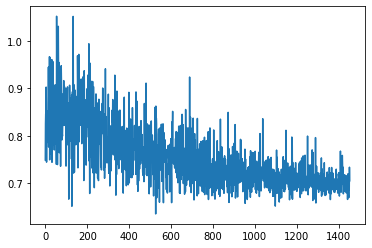

In [678]:
plt.plot([x.detach().numpy() for x in train_losses])

In [679]:
def validate_model(model, split='val', seq_length = 30, exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')]):
    from torch.utils.data import dataset, dataloader, SequentialSampler
    dl = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length= seq_length, split = split, batch_size = 1, pxcol = '__CC1_ID_Close', exog = exog, dateformat = '%m/%d/%Y')


    predictions, val_losses, actuals = model.test(dl)
    predictions = predictions.flatten()
    actuals = np.array(actuals)

    from backtester import backtest_log
    scaled_returns, actual_returns, strategy_predictors = backtest_log(predictions, actuals)
    return scaled_returns, actual_returns, strategy_predictors

AVERAGE LOSS:  0.7027425
Long only annualized psuedo sharpe:  0.04724533824185747
Strategy annualized psuedo sharpe:  -0.007030252130075222
Correlation matrix between strategy predictors and returns
[[1.         0.00237046]
 [0.00237046 1.        ]]
Avg. Portfolio Allocation,  0.08062199
Percent of time predicted direction correctly:  47.06529209621993
Percent of time long:  45.786941580756015


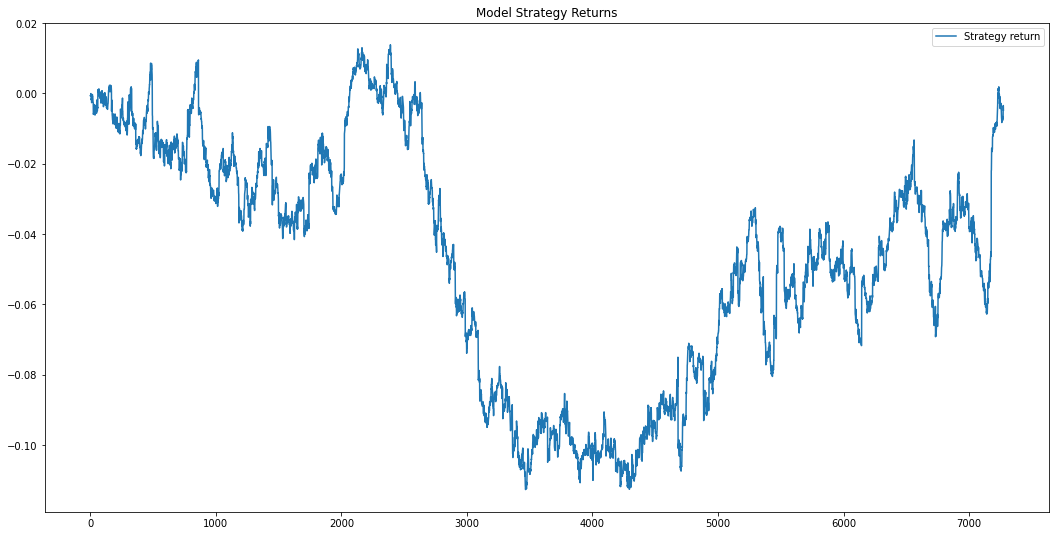

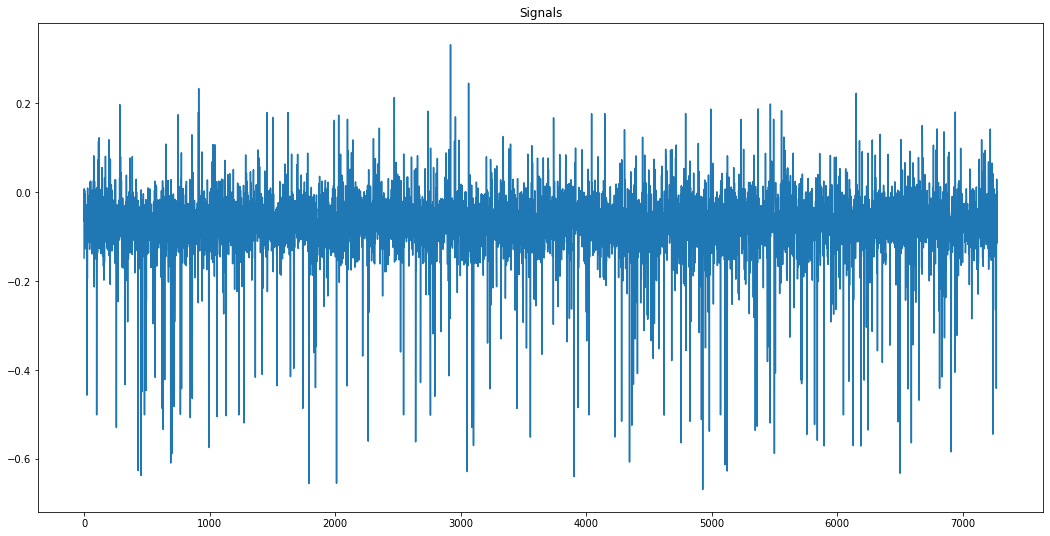

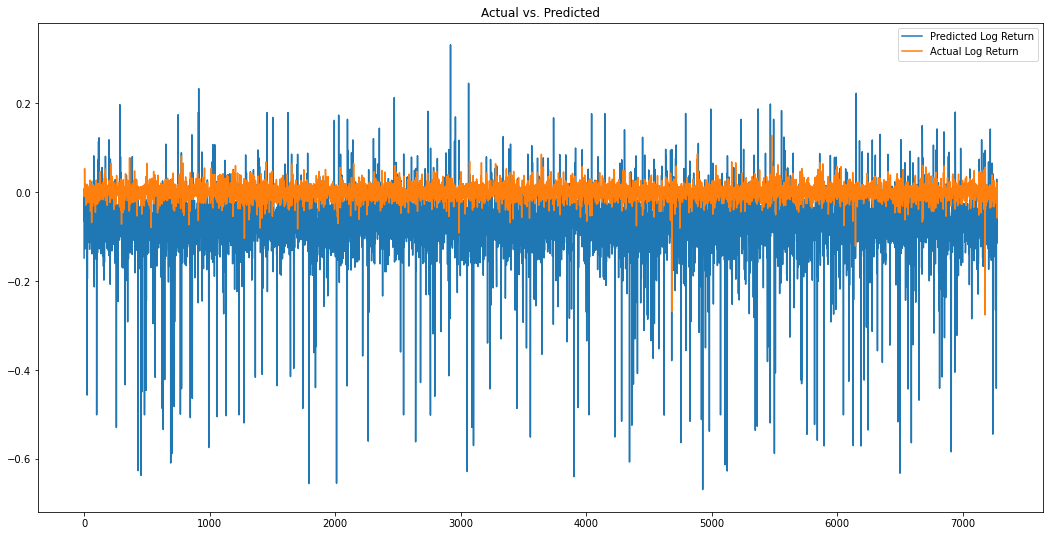

In [680]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train')

In [681]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03994
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.842
Time:                        21:01:08   Log-Likelihood:                 19402.
No. Observations:                7275   AIC:                        -3.880e+04
Df Residuals:                    7273   BIC:                        -3.879e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.863e-05      0.000      0.281      0.779      -0.001       0.001
x1             0.0005      0.003      0.200      0.842      -0.005       0.006
==============================================================================
Omnibus:                     2906.557   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146648.044
Skew:                          -1.149   Prob(JB):                         0.00
Kurtosis:                      24.875   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

AVERAGE LOSS:  0.69726557
Long only annualized psuedo sharpe:  0.07356159551788474
Strategy annualized psuedo sharpe:  -0.10228808714211468
Correlation matrix between strategy predictors and returns
[[ 1.         -0.00765691]
 [-0.00765691  1.        ]]
Avg. Portfolio Allocation,  0.059538055
Percent of time predicted direction correctly:  45.627376425855516
Percent of time long:  41.06463878326996


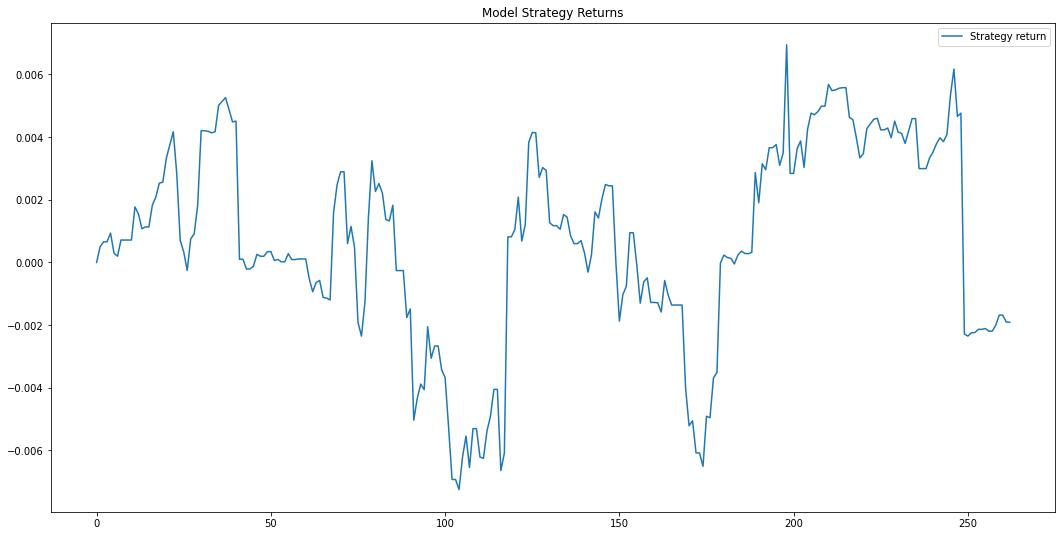

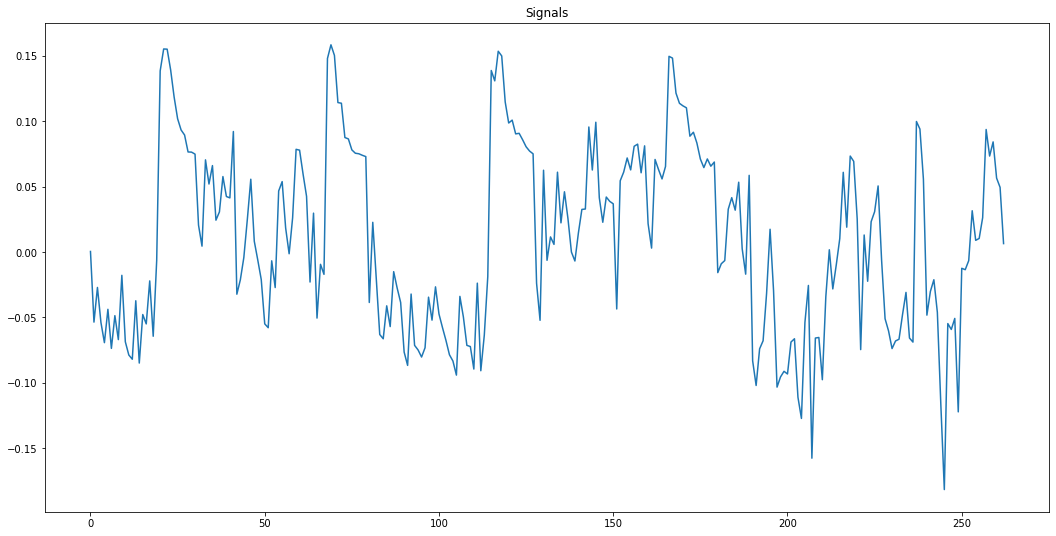

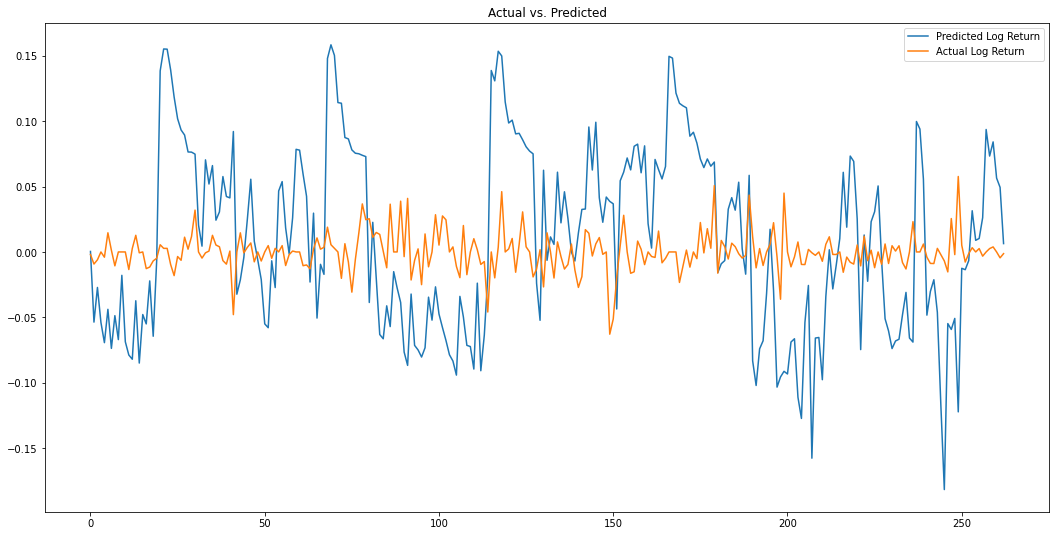

In [682]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test')

In [683]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01509
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.902
Time:                        21:01:25   Log-Likelihood:                 732.26
No. Observations:                 263   AIC:                            -1461.
Df Residuals:                     261   BIC:                            -1453.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.561e-05      0.001      0.087      0.931      -0.002       0.002
x1            -0.0016      0.013     -0.123      0.902      -0.028       0.025
==============================================================================
Omnibus:                       29.780   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.426
Skew:                           0.256   Prob(JB):                     1.75e-29
Kurtosis:                       6.438   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

# NON MULTI TASK WITH EXOGENOUS

In [684]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [x for x in read_csv.columns if (x != 'Date') & (x != '__CC1_ID_Close')], dateformat = '%m/%d/%Y')

testlstm = LSTM.CommodityLSTM(num_features = 13, )
train_losses, _ = testlstm.train(train_loader, epochs = 4)

  0%|          | 0/4 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.15476839244365692
TRAINING BATCH LOSS AT STEP 700: 0.07550550997257233


 25%|██▌       | 1/4 [00:15<00:46, 15.43s/it]

TRAINING BATCH LOSS AT STEP 0: 0.058391012251377106
TRAINING BATCH LOSS AT STEP 700: 0.00615454139187932


 50%|█████     | 2/4 [00:30<00:30, 15.40s/it]

TRAINING BATCH LOSS AT STEP 0: 0.005183611065149307
TRAINING BATCH LOSS AT STEP 700: 0.000400866090785712


 75%|███████▌  | 3/4 [00:46<00:15, 15.52s/it]

TRAINING BATCH LOSS AT STEP 0: 0.0063197375275194645
TRAINING BATCH LOSS AT STEP 700: 0.005887608043849468


100%|██████████| 4/4 [01:01<00:00, 15.36s/it]


AVERAGE LOSS:  0.004763783
Long only annualized psuedo sharpe:  0.04724538259472008
Strategy annualized psuedo sharpe:  0.08843405654563238
Correlation matrix between strategy predictors and returns
[[1.         0.00616023]
 [0.00616023 1.        ]]
Avg. Portfolio Allocation,  0.03900906
Percent of time predicted direction correctly:  44.96219931271478
Percent of time long:  45.786941580756015


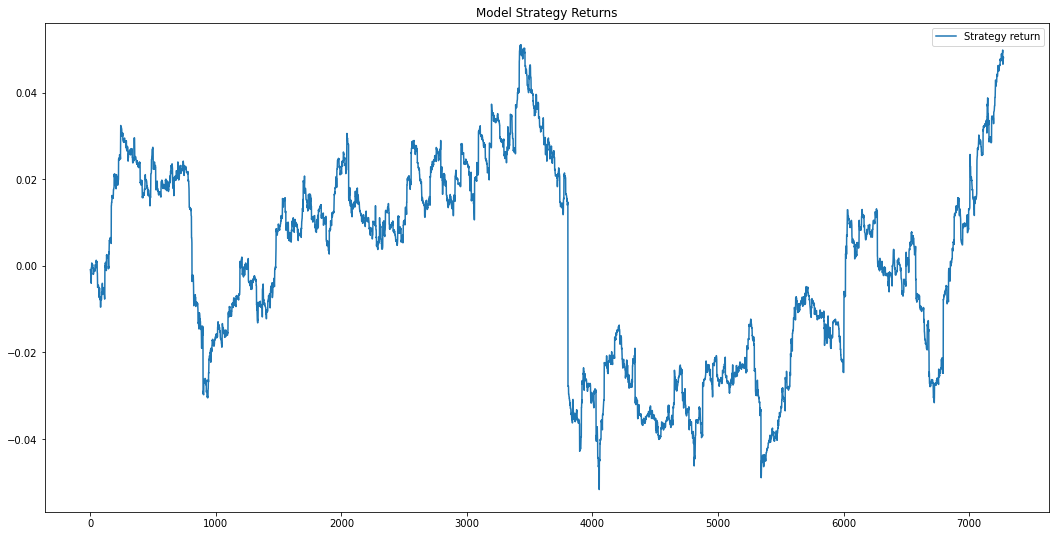

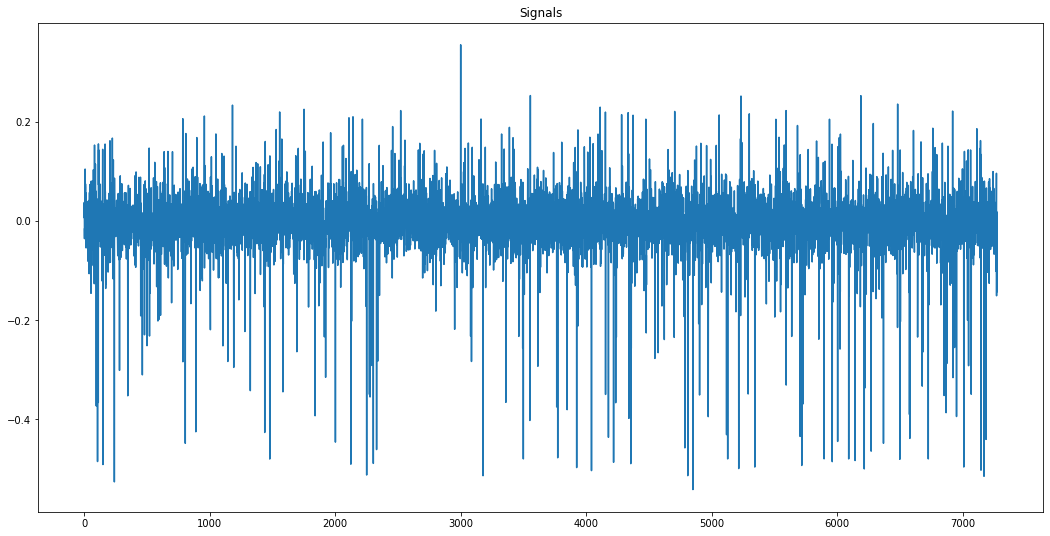

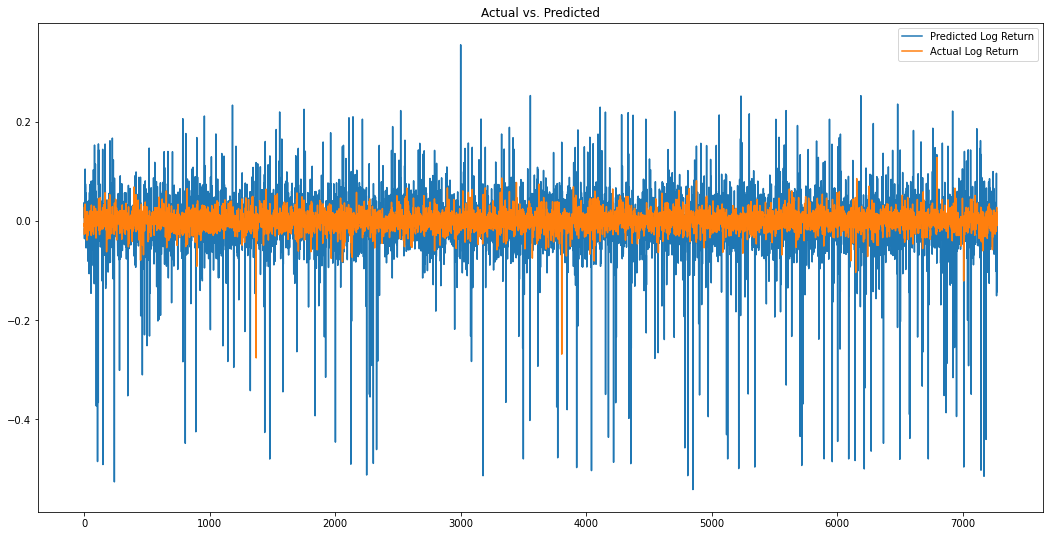

In [685]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train')

In [686]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2379
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.626
Time:                        21:05:15   Log-Likelihood:                 19402.
No. Observations:                7275   AIC:                        -3.880e+04
Df Residuals:                    7273   BIC:                        -3.879e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.951e-05      0.000      0.291      0.771      -0.000       0.000
x1             0.0016      0.003      0.488      0.626      -0.005       0.008
==============================================================================
Omnibus:                     2912.926   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146894.383
Skew:                          -1.154   Prob(JB):                         0.00
Kurtosis:                      24.892   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

AVERAGE LOSS:  0.009456199
Long only annualized psuedo sharpe:  0.07356159551788474
Strategy annualized psuedo sharpe:  0.10704408895271549
Correlation matrix between strategy predictors and returns
[[1.         0.00517533]
 [0.00517533 1.        ]]
Avg. Portfolio Allocation,  0.07779586
Percent of time predicted direction correctly:  41.44486692015209
Percent of time long:  41.06463878326996


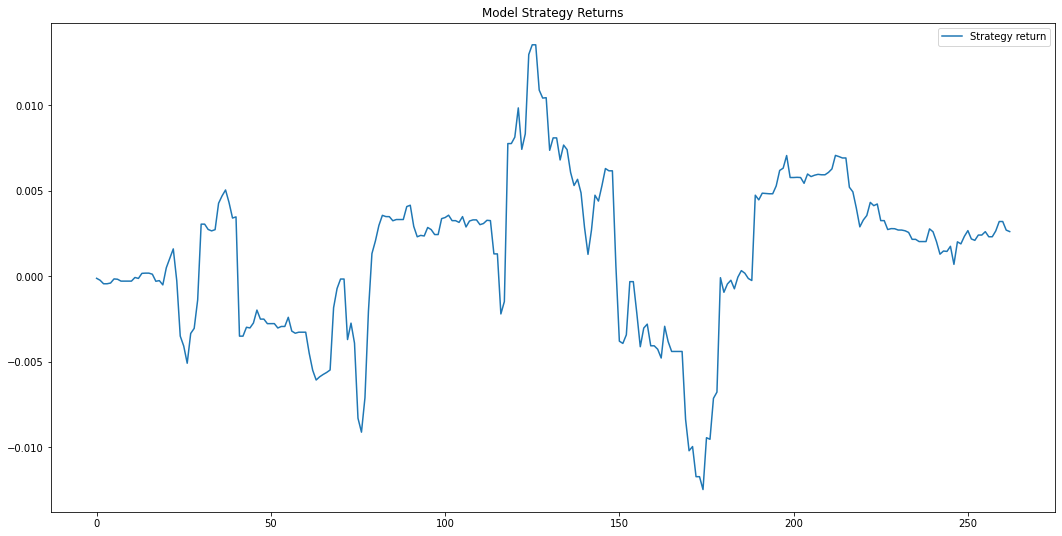

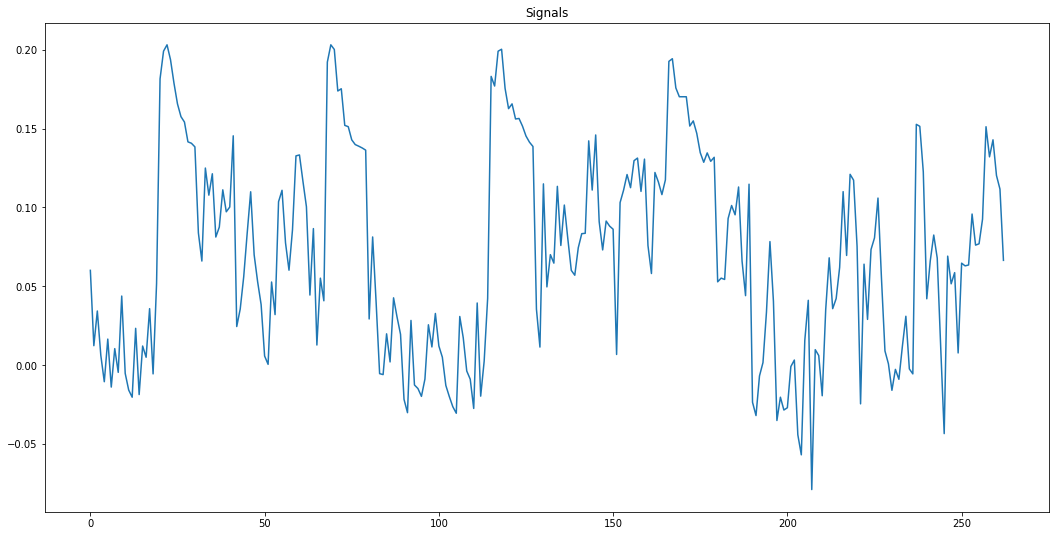

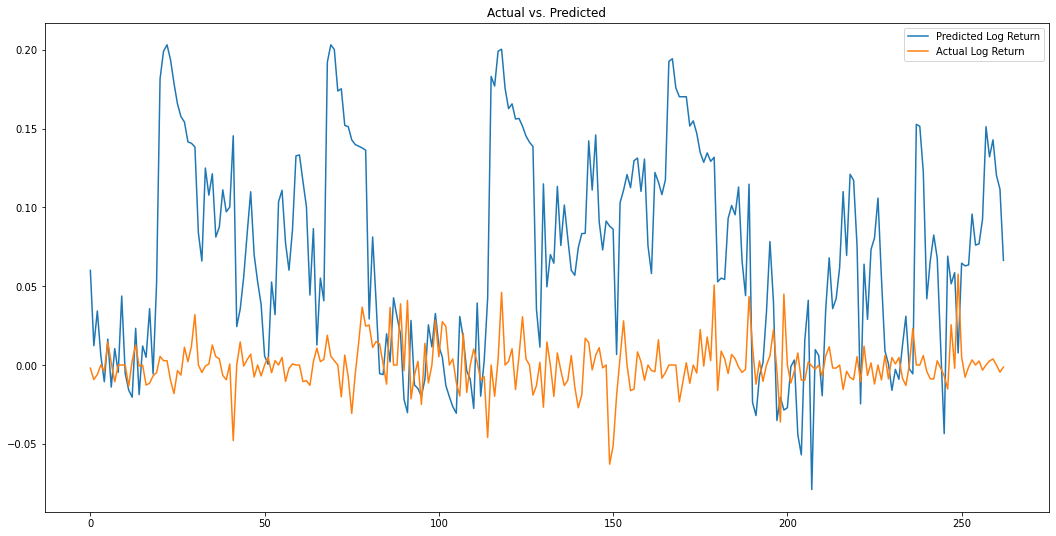

In [687]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test')

In [688]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.007482
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.931
Time:                        21:05:40   Log-Likelihood:                 732.25
No. Observations:                 263   AIC:                            -1461.
Df Residuals:                     261   BIC:                            -1453.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.637e-05      0.001     -0.012      0.990      -0.003       0.003
x1             0.0012      0.014      0.086      0.931      -0.026       0.028
==============================================================================
Omnibus:                       29.929   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.080
Skew:                           0.255   Prob(JB):                     7.67e-30
Kurtosis:                       6.460   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

# ONE TIME SERIES

In [689]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)
/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


In [690]:
testlstm = LSTM.CommodityLSTM(num_features = 1)
train_losses, _ = testlstm.train(train_loader, epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.023264532908797264
TRAINING BATCH LOSS AT STEP 700: 0.0010671598138287663


 50%|█████     | 1/2 [00:15<00:15, 15.38s/it]

TRAINING BATCH LOSS AT STEP 0: 0.000976316339801997
TRAINING BATCH LOSS AT STEP 700: 0.00010236793605145067


100%|██████████| 2/2 [00:30<00:00, 15.30s/it]


/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.00028246423
Long only annualized psuedo sharpe:  0.04724537520257631
Strategy annualized psuedo sharpe:  0.2339750553056365
Correlation matrix between strategy predictors and returns
[[1.         0.01768464]
 [0.01768464 1.        ]]
Avg. Portfolio Allocation,  0.00032572632
Percent of time predicted direction correctly:  46.666666666666664
Percent of time long:  45.786941580756015


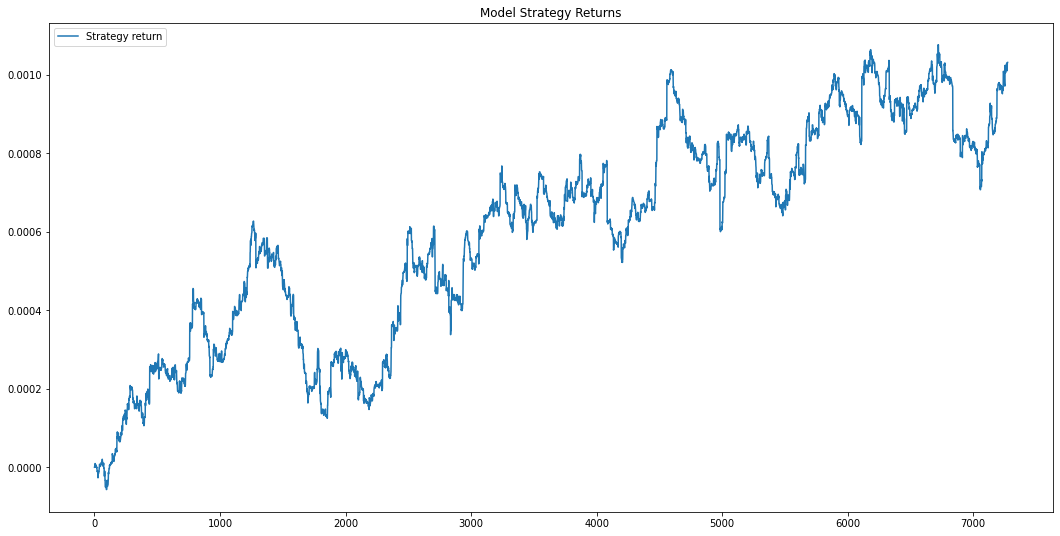

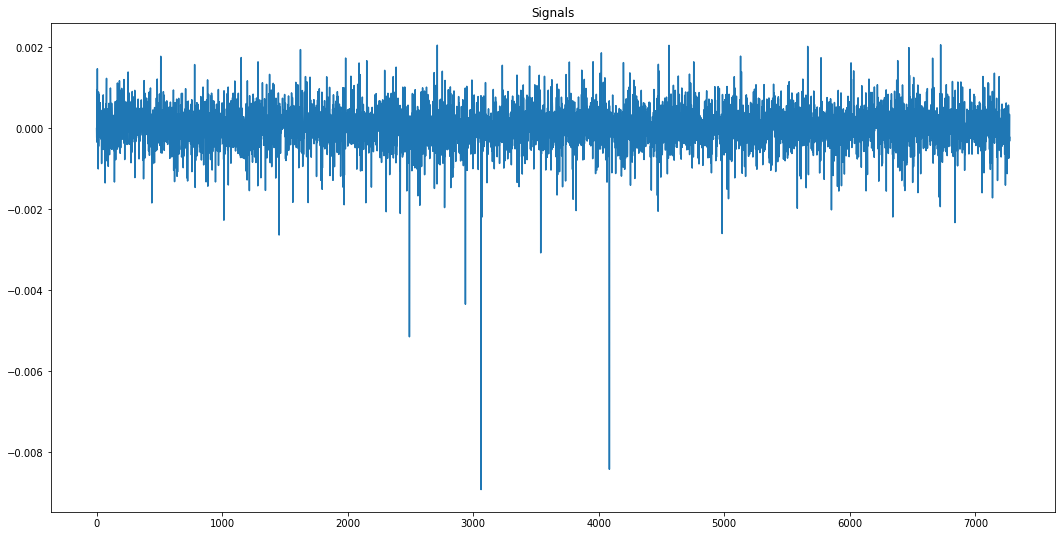

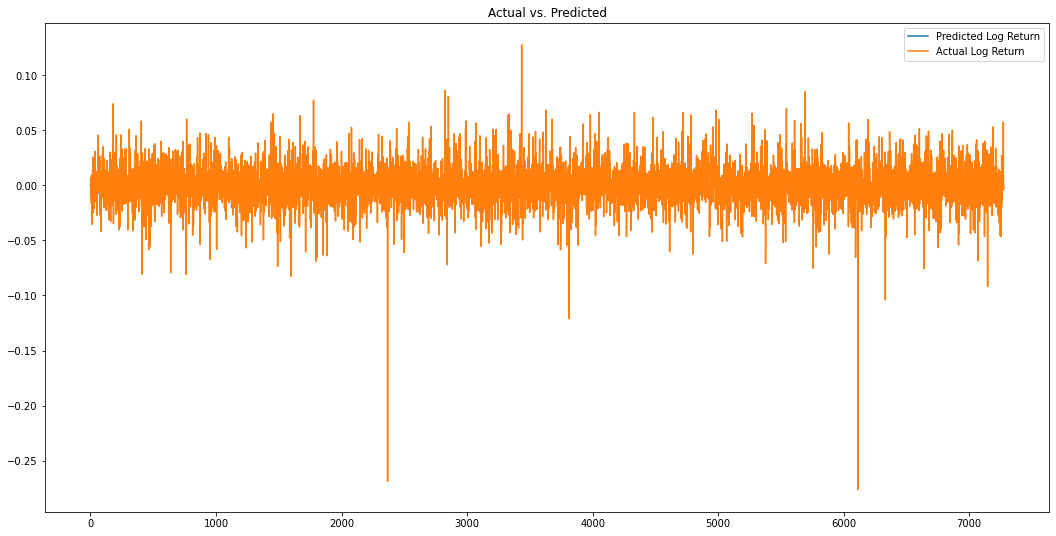

In [691]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train', exog = [])

In [692]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.522
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.217
Time:                        21:06:39   Log-Likelihood:                 19403.
No. Observations:                7275   AIC:                        -3.880e+04
Df Residuals:                    7273   BIC:                        -3.879e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.651e-05      0.000      0.134      0.893      -0.000       0.000
x1             0.6313      0.512      1.234      0.217      -0.372       1.634
==============================================================================
Omnibus:                     2892.670   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145725.785
Skew:                          -1.141   Prob(JB):                         0.00
Kurtosis:                      24.807   Cond. No.                     2.12e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.00022247038
Long only annualized psuedo sharpe:  0.07356159551788474
Strategy annualized psuedo sharpe:  1.2040496450511642
Correlation matrix between strategy predictors and returns
[[1.         0.09130547]
 [0.09130547 1.        ]]
Avg. Portfolio Allocation,  0.0002958369
Percent of time predicted direction correctly:  42.96577946768061
Percent of time long:  41.06463878326996


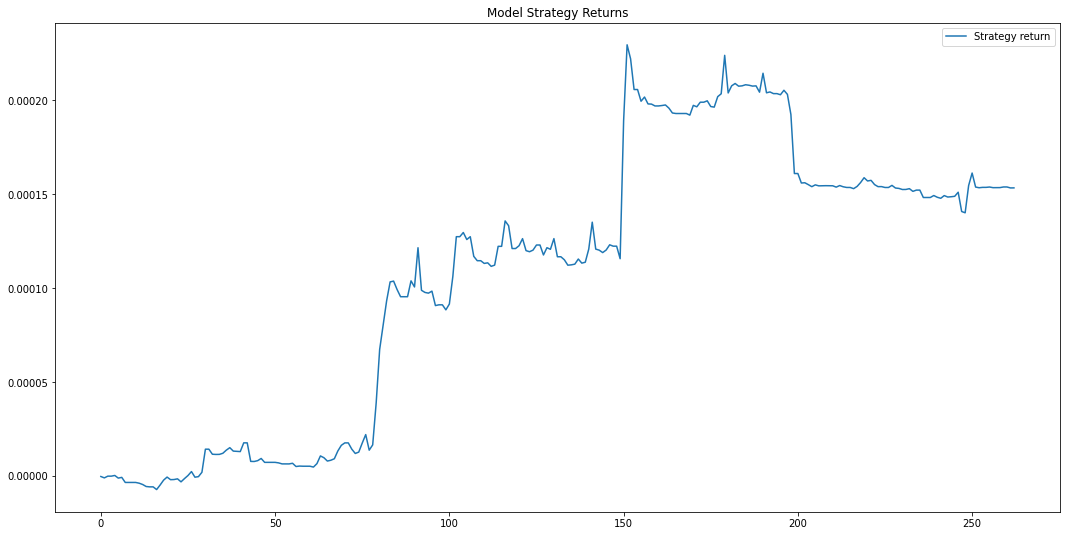

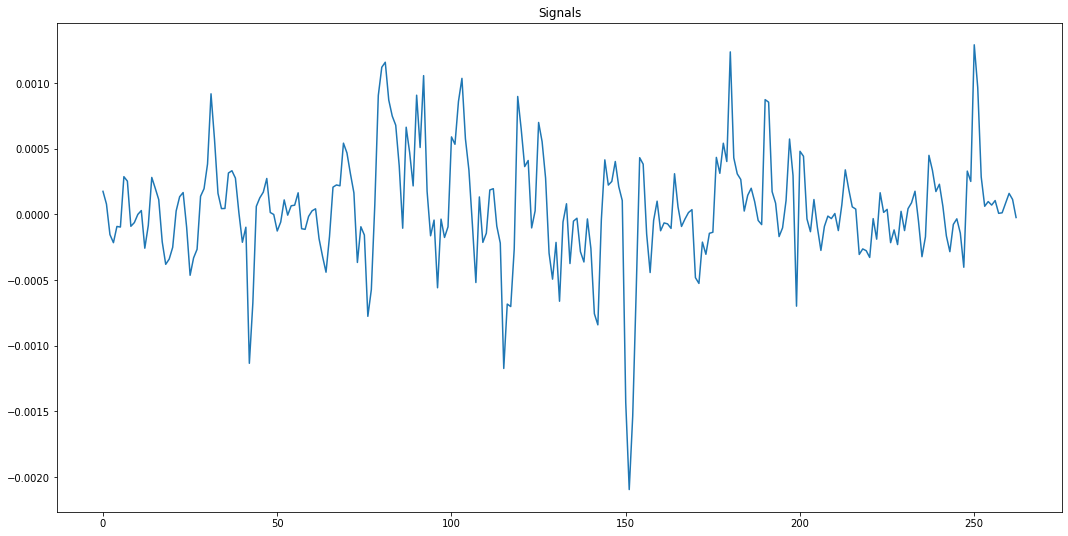

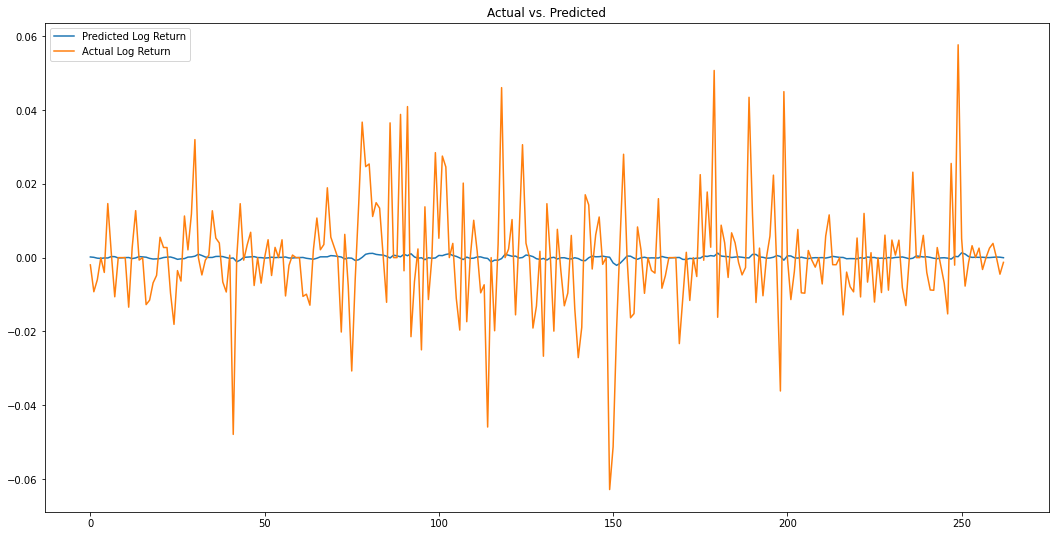

In [693]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test', exog = [])

In [694]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.754
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.187
Time:                        21:06:51   Log-Likelihood:                 733.35
No. Observations:                 263   AIC:                            -1463.
Df Residuals:                     261   BIC:                            -1456.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.772e-05      0.001     -0.075      0.941      -0.002       0.002
x1             3.2115      2.425      1.324      0.185      -1.542       7.965
==============================================================================
Omnibus:                       30.380   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.419
Skew:                           0.305   Prob(JB):                     2.14e-28
Kurtosis:                       6.355   Cond. No.                     2.35e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 2.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# ONE TIME SERIES WITH DIRECTIONALITY

In [697]:
train_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'train', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')
validation_loader = dataloader_cm.get_dataloader_exog(filepath='commodities', seq_length = 30, split = 'val', batch_size = 10, pxcol = '__CC1_ID_Close', exog = [], dateformat = '%m/%d/%Y')

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)
/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


In [698]:
testlstm = LSTM.CommodityLSTM(num_features = 1)
train_losses, _ = testlstm.train(train_loader, epochs = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

TRAINING BATCH LOSS AT STEP 0: 0.6885142922401428
TRAINING BATCH LOSS AT STEP 700: 0.6962937116622925


 33%|███▎      | 1/3 [00:15<00:31, 15.82s/it]

TRAINING BATCH LOSS AT STEP 0: 0.7055165767669678
TRAINING BATCH LOSS AT STEP 700: 0.6916103959083557


 67%|██████▋   | 2/3 [00:31<00:15, 15.70s/it]

TRAINING BATCH LOSS AT STEP 0: 0.6897284984588623
TRAINING BATCH LOSS AT STEP 700: 0.6960646510124207


100%|██████████| 3/3 [00:46<00:00, 15.35s/it]


/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.6930365
Long only annualized psuedo sharpe:  0.0472454010750795
Strategy annualized psuedo sharpe:  -0.03914432484674417
Correlation matrix between strategy predictors and returns
[[1.         0.01852314]
 [0.01852314 1.        ]]
Avg. Portfolio Allocation,  0.018221695
Percent of time predicted direction correctly:  46.69415807560137
Percent of time long:  45.786941580756015


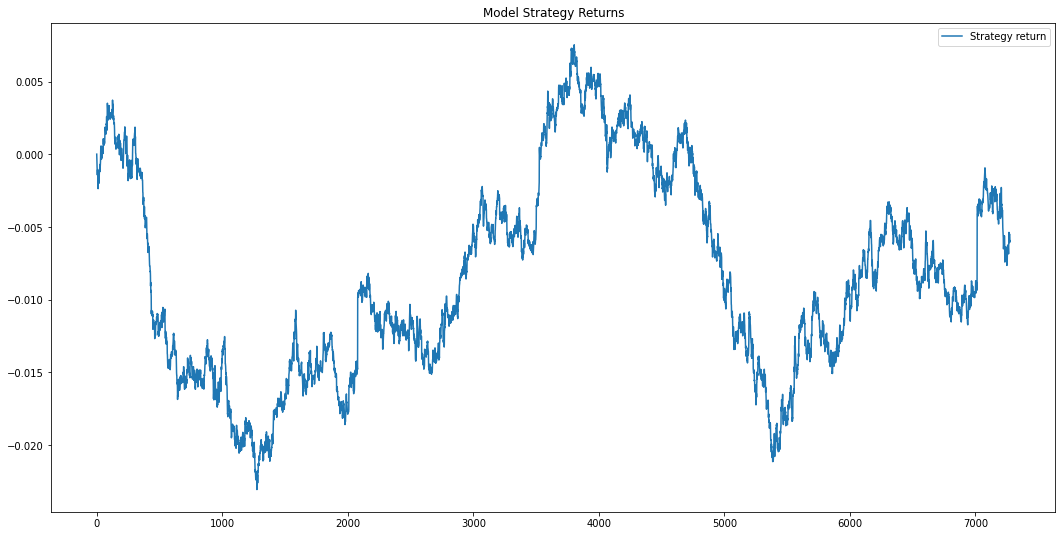

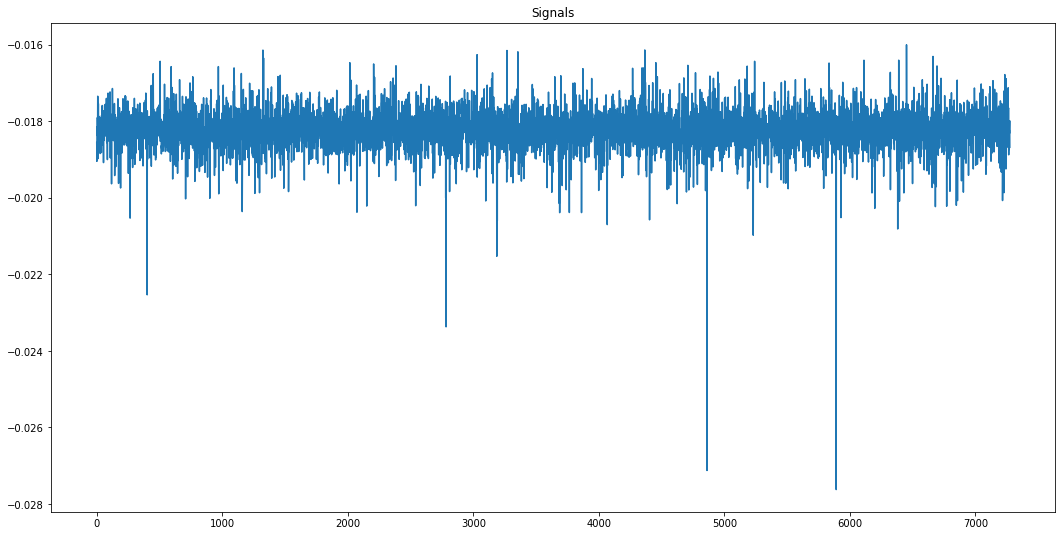

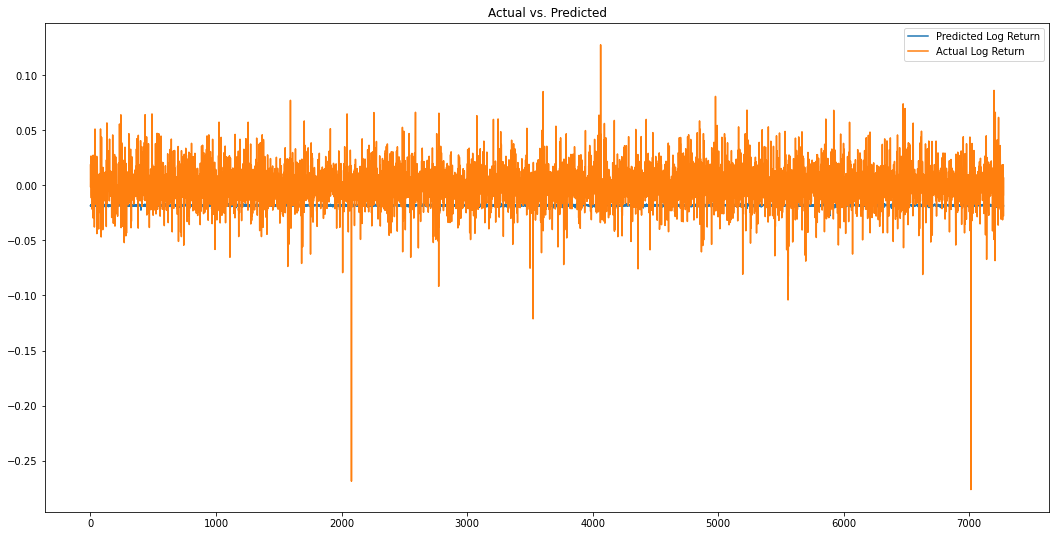

In [700]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'train', exog = [])

In [701]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.671
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.196
Time:                        21:16:28   Log-Likelihood:                 19403.
No. Observations:                7275   AIC:                        -3.880e+04
Df Residuals:                    7273   BIC:                        -3.879e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.009      1.302      0.193      -0.006       0.029
x1             0.6327      0.489      1.293      0.196      -0.327       1.592
==============================================================================
Omnibus:                     2891.912   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145654.178
Skew:                          -1.140   Prob(JB):                         0.00
Kurtosis:                      24.802   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/bodhinguyen/Desktop/Stanford/STATS207/stats_207/dataloader_cm.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Date'] = pd.to_datetime(self.data['Date'], format = dateformat)


AVERAGE LOSS:  0.692115
Long only annualized psuedo sharpe:  0.07356159551788474
Strategy annualized psuedo sharpe:  -0.03714540416210496
Correlation matrix between strategy predictors and returns
[[1.         0.09365583]
 [0.09365583 1.        ]]
Avg. Portfolio Allocation,  0.018216357
Percent of time predicted direction correctly:  43.72623574144487
Percent of time long:  41.06463878326996


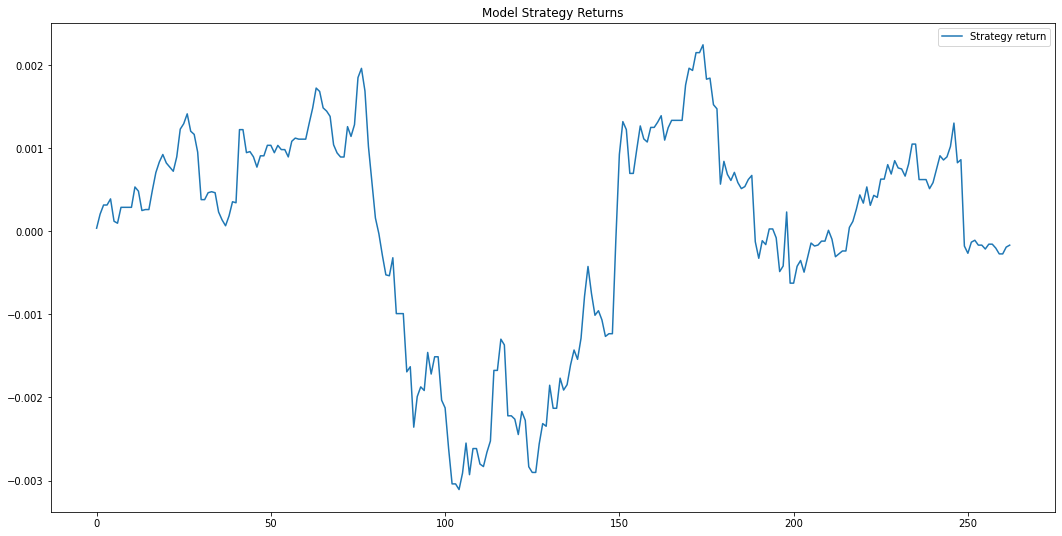

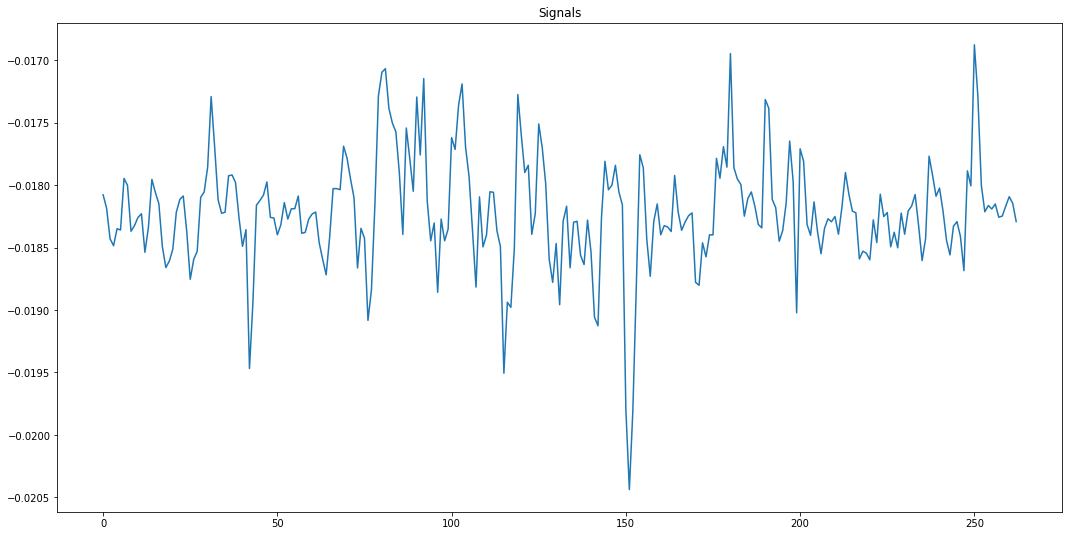

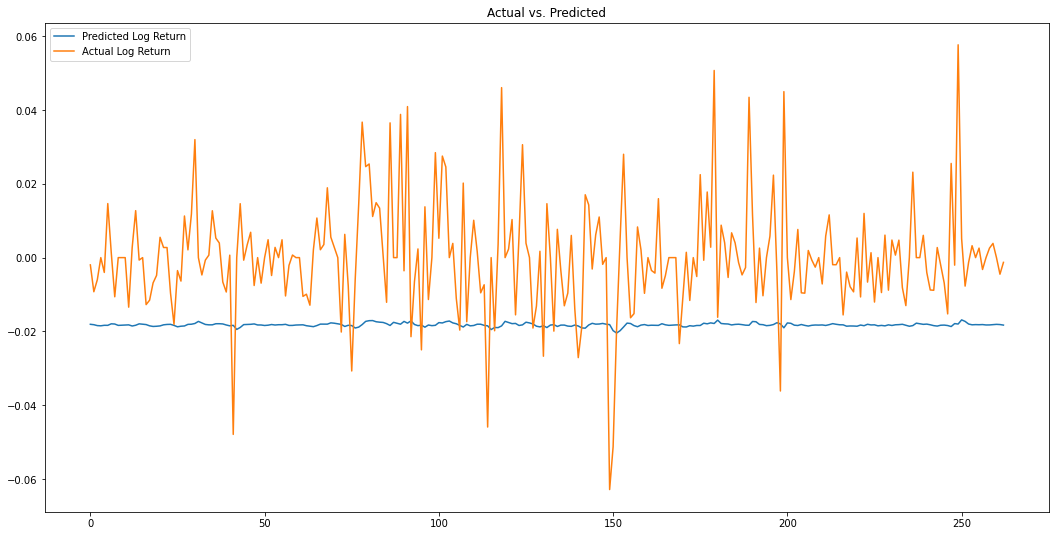

In [702]:
strategy_returns, long_only_returns, strategy_predictors = validate_model(testlstm, 'test', exog = [])

In [703]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(long_only_returns, sm.add_constant(strategy_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 5})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.778
Date:                Sun, 28 Nov 2021   Prob (F-statistic):              0.184
Time:                        21:16:41   Log-Likelihood:                 733.41
No. Observations:                 263   AIC:                            -1463.
Df Residuals:                     261   BIC:                            -1456.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0575      0.043      1.337      0.181      -0.027       0.142
x1             3.1531      2.365      1.333      0.182      -1.482       7.788
==============================================================================
Omnibus:                       30.450   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.415
Skew:                           0.308   Prob(JB):                     2.15e-28
Kurtosis:                       6.354   Cond. No.                     2.25e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""